# PyTorch: Autoencoder convolucional Fashion-MNIST

## Refs.

* https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

* https://github.com/zalandoresearch/fashion-mnist

* https://github.com/pranay414/Fashion-MNIST-Pytorch/blob/master/fashion_mnist.ipynb

## **Ejercicio 1)** Importando librerías

**0)** De ser necesario, **instale PyTorch** escribiendo

    !pip3 install torch torchvision torchaudio torchviz

**1)** Importe las librerías estandard de Python: `os`, `datetime`, `collections` y `pickle`.

**2)** Importe las siguientes librerías third party de Python: `matplotlib.pyplot`, `numpy`, `scipy`, `sklearn`, `pandas`, `dill` y `json`.

**3)** Importe las librerias necesarias de **PyTorch**: `torch` y `torchvision`.

**4)** Importe la librería: `google.colab`.

In [1]:
# 1.0)
#!pip3 install torch torchvision torchaudio torchviz

In [2]:
# 1.1)
import os
import pickle
import datetime
from collections import defaultdict

In [3]:
# 1.2)
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import sklearn as skl
import pandas as pd
#import dill
import json

In [4]:
# 1.3)
import torch
import torch.optim as optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda, Compose
#from torchviz import make_dot

In [5]:
# 1.4)
#import google.colab
#from google.colab import files

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## **Ejercicio 2)**

Bajando y Jugando con el dataset **Fashion-MNIST**.

**1)** Baje y transforme los conjuntos de entrenamiento y testeo de FashionMNIST.

**2)** Grafique un mosaico de 3x3 imagenes de FashionMNIST, cada una titulada con su respectiva clasificación

In [7]:
# 2.1)
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
train_set_orig = datasets.FashionMNIST('MNIST_data/', download = True, train = True,  transform = transform)
valid_set_orig = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)

100%|██████████| 26421880/26421880 [00:07<00:00, 3368267.92it/s]


Extracting MNIST_data/FashionMNIST\raw\train-images-idx3-ubyte.gz to MNIST_data/FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 124266.97it/s]


Extracting MNIST_data/FashionMNIST\raw\train-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:02<00:00, 1985178.10it/s]


Extracting MNIST_data/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to MNIST_data/FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<?, ?it/s]

Extracting MNIST_data/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST\raw



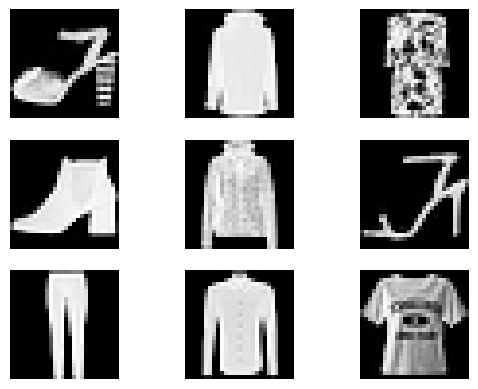

In [8]:
# 2.2)
figure = plt.figure()
cols,rows = 3,3
for i in range(1,cols*rows+1):
    j = torch.randint(len(train_set_orig),size=(1,)).item() # Los números aleatorios tambien se pueden generar desde pytorch. Util para trabajar en la GPU.
    image,label = train_set_orig[j]
    figure.add_subplot(rows,cols,i)
    #plt.title(labels_names[label])
    plt.axis("off")
    plt.imshow(image.squeeze(),cmap="Greys_r")
plt.show()

## Ejercicio 3) Creando un `DataSet` personalizado.

**1)** Con el fin de implementar un autoencoder, cree una clase derivada de la clase `DataSet` (llámela, por ejemplo `CustomDataset`) que, en vez de retornal el label asociado a cada imagen de `FashionMNIST`, retorne la imagen misma.

**2)** Utilice dicha clase para transformar los conjuntos de entrenamiento y testeo de `FashionMNIST` pensados para clasificación, a correspondientes conjuntos pensados para entrenar un autoencoder.
Para ello, defina una clase `CustomDataset` que deriva de la clase `Dataset`, cuyo método `__getitem__(self,i)` retorne el pair `input,output` donde tanto `input` cómo `output` son iguales a la $i$-ésima imagen del dataset.

In [ ]:
# 3.1)

class CustomDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        # Originalmente, retorna imagen y etiqueta
        image, label = self.dataset[index] 

        # Modificamos el dataset para que retorne solo la imagen
        input = image
        output = image
        return input, output 

In [ ]:
# 3.2)

train_set = CustomDataset(train_set_orig)
valid_set = CustomDataset(valid_set_orig)

## Ejercicio 4) Red Neuronal Autoencoder Convolucional

**1)** Defina y cree una red neuronal *autoenconder convolucional* constituida por las siguientes capas:

1. Una capa convolucional 2D constituida por:

* Una capa `Conv2d` (ver https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) que deberá mapear $1$ canal de entradas de dimensiones $(28,28)$ a $16$ canales de de salida de dimensiones $(26,26)$. Para ello utilice un kernel de dimensiones $(3,3)$ y el resto de los parámetros en sus valores por defecto.
* Una capa `ReLU`.
* Una capa `Dropout`.
* Una capa `MaxPool` (ver https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) con un kernel de dimensiones $(2,2)$, de manera que mapeará entradas de dimensiones $(26,26)$ a salidas de dimensiones $(13,13)$.

2. Una capa lineal constituida por:

* Una capa `Flatten` que mapea una entrada de $16$ canales de dimensiones $(13,13)$ a un vector de dimensión $16\times 13\times 13$.
* Una capa `Linear` que mapea un vector de dimensión $16\times 13\times 13$ a un vector de dimensión $n$.
* Una capa `ReLU`.
* Una capa `Dropout`.

3. Una capa capa convolucional 2D transpuesta, constituida por:

* una capa `ConvTranspose2d` (ver https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) que mapea $16$ canales de dimensiones $(13,13)$ a $1$ canal de dimensiones $(28,28)$. Para ello, utilice un kernel de dimensiones $(6,6)$ y un stride de dimensiones $(2,2)$, dejando el resto de los parámetros en sus valores por defecto, i.e. padding de $(1,1)$ y out_padding de $(0,0)$.

* Una capa `Sigmoid`.

**3)** Grafique, a modo de comparación, unas pocas imagenes a predecir vs las correspondientes imagenes predichas utilizando el modelo sin entrenar y dropout $p=0.2$.

In [ ]:
# 4.1)

# Calcula el tamaño de salida de una capa convolucional transpuerta
def convt2d_out(z_in, stride, padding, dilation, kernel_size, output_padding):
    z_out = (z_in-1)*stride - 2*padding + dilation*(kernel_size-1) + output_padding + 1
    return z_out

In [14]:
convt2d_out(13, 2, 1, 1, 6, 0)

28

In [17]:
class AutoEncoder(nn.Module):
    def __init__(self, p=0.2):
        super(AutoEncoder, self).__init__()
        self.flatten = nn.Flatten()

        # Encoder
        self.conv2d = nn.Sequential(

            # 1 canal de 28x28 a 16 canales de 26x26. Este tamaño se debe al kernel y padding=0
            nn.Conv2d(1, 16, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.Dropout(p),
            # Salida se reduce a la mitad, es decir, 13x13
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Linear
        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16*13*13, 16*13*13 ),
            nn.ReLU(),
            nn.Dropout(p),
        )
        
        # Decoder
        self.convt2d = nn.Sequential(
            nn.Unflatten(1, (16,13,13)),
            nn.ConvTranspose2d(16, 1, kernel_size=6, stride=2, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.conv2d(x) # Encoder
        x = self.linear(x)
        x = self.convt2d(x) # Decoder 
        return x

In [18]:
p = 0.2
model = AutoEncoder(p=p)

In [ ]:
# Prueba

image = torch.randn(1,1,28,28) # Batch, canal, size
output = model(image)
print(f'Input size: {image.shape}')
print(f'Output size: {output.shape}')

Input size: torch.Size([1, 1, 28, 28])
Output size: torch.Size([1, 1, 28, 28])


In [20]:
def batch(x):
    return x.unsqueeze(0) # (28, 28) -> (1, 28, 28)

def unbatch(x):
    return x.squeeze().detach().cpu().numpy() # (1, 28, 28) -> (28, 28)

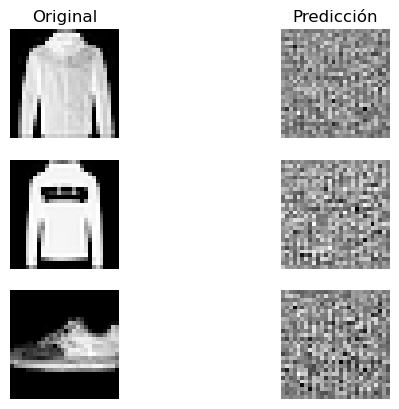

In [22]:
# Prueba del modelo sin entrenar

figure = plt.figure()
rows,cols = 3,2

i = 0

for row in range(1, rows+1):
    j = torch.randint(len(train_set),size=(1,)).item() # Los números aleatorios tambien se pueden generar desde pytorch. Util para trabajar en la GPU.  
    i += 1
    image, _ = train_set[j]
    figure.add_subplot(rows, cols, i)

    if row == 1:
        plt.title('Original')
    plt.axis('off')

    plt.imshow(unbatch(image), cmap='Greys_r')

    i += 1
    figure.add_subplot(rows, cols, i)

    if row ==1:
        plt.title('Predicción')
    plt.axis('off')
    image_pred = unbatch(model(batch(image)))
    plt.imshow(image_pred, cmap='Greys_r')

plt.show()

Sin entrenar solo genera ruido

## Ejercicio 5) Entrenando el modelo

**1)** Implemente, en una función, un loop de entrenamiento que recorra los batchs (lotes).

**2)** Implemente, en una función, un loop de prueba o validación que recorra los batchs.

**3)** Inicialize dos `DataLoader`s llamados `train_loader` y `valid_loader` que estén definidos sobre  el `train_set` (conjunto de entranmiento) y el `valid_set` (conjunto de prueba) de Fashion-MNIST, respectivamente, y que usen batchs de 100 ejemplos.

**4)** Cree una función de pérdida usando el **Error Cuadrático Medio**.

**5)** Cree un optimizador con un learning rate igual a $10^{-3}$.
Pruebe con **ADAM**.

**6)** Cree una instancia del modelo con dropout $p=0.2$.

**7)** Especifique en que dispositivo (`device`) va a trabajar: en una **CPU** o en una **GPU**.

**8)** Implemente un loop que itere sobre épocas de entrenamiento y validación, y que guarde en listas correspondientes los siguientes valores del **ECM**:
*  promedios (incorrectos) sobre el conjunto de entrenamiento, calculado **durante** el proceso de entrenamiento sobre la época.
*  promedios (correctos) sobre el conjunto de entrenamiento, calculados **posteriormente** al proceso de entrenamiento sobre la época.
*  promedios (correctos) sobre el conjunto de validación, calculados **posteriormente** al proceso de entrenamiento sobre la época.

**IMPORTANTE:** No olvide copiar los batchs al dispositivo de trabajo.

**9)** Entrene y valide el modelo.

**10)** Use las listas del inciso **8)** para graficar en función de las **épocas de entrenamiento** el **ECM** de **entrenamiento** y **validación**, respectivamente.
Discuta y comente, cual es el número óptimo de épocas de entrenamiento?

**11)** Grafique, comparativamente, algunas de las imagenes a predecir vs las imagenes predichas por el modelo entrenado.

**12)** Repita para otras elecciones de los hiperparámetros tales como, el optimizador (podría ser el **SGD**), el **learning-rate**, el tamaño de los **batchs**, el **dropout**, **capas convolucionales** y **convolucionales traspuestas** de otros tamaños.
En particular, pruebe eliminando, adecuadamente, la **capa lineal**.
Que valores de estos hiperparámetros considera los más convenientes? Porqué?

In [23]:
# 5.1)

def train_loop(dataloader, model, loss_fn, optimizer, verbose=True):
    model.train()

    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)

    sum_batch_avrg_loss = 0
    num_processed_samples = 0

    model = model.to(device)

    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)

        batch_size = len(X)
        num_processed_samples += batch_size	

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_avrg_loss = loss.item()
        sum_batch_avrg_loss += batch_avrg_loss

        if batch % (num_batches/10) == 0 and verbose:
            current = batch*len(X)
            print(f'Batch {batch:>5d} | Loss: {batch_avrg_loss:.6f} | Processed: {100 * num_processed_samples / num_samples:.2f}%')

    avrg_loss = sum_batch_avrg_loss / num_batches
    return avrg_loss

In [24]:
def eval_loop(dataloader, model, loss_fn):
    model.eval()

    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)

    sum_batch_avrg_loss = 0
    num_processed_samples = 0

    model = model.to(device)

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            batch_size = len(X)
            num_processed_samples += batch_size

            pred = model(X)
            loss = loss_fn(pred, y)

            batch_avrg_loss = loss.item()
            sum_batch_avrg_loss += batch_avrg_loss

    avrg_loss = sum_batch_avrg_loss / num_batches

    return avrg_loss

In [25]:
# 5.3

batch_size = 100
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size = batch_size, shuffle=True)

num_train_batches = len(train_loader)
num_valid_batches = len(valid_loader)
print('num_train_batches: ', num_train_batches)
print('num_valid_batches: ', num_valid_batches)

num_train_batches:  600
num_valid_batches:  100


In [26]:
# 5.4)

loss_fn = nn.MSELoss()

In [28]:
# 5.5)

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, eps=1e-8, weight_decay=0, amsgrad=False)

In [29]:
# 5.6) 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [30]:
# 5.8)

num_epochs = 10
list_avg_train_loss_incorrecta = []
list_avg_train_loss = []
list_avg_valid_loss = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}\\n' + '-' * 20)
    avg_train_loss_incorrecta = train_loop(train_loader, model, loss_fn, optimizer)
    avg_train_loss = eval_loop(train_loader, model, loss_fn)
    avg_valid_loss = eval_loop(valid_loader, model, loss_fn)

    list_avg_train_loss_incorrecta.append(avg_train_loss_incorrecta)
    list_avg_train_loss.append(avg_train_loss)
    list_avg_valid_loss.append(avg_valid_loss)  

    print('avg_train_loss_incorrecta: ', avg_train_loss_incorrecta)
    print('avg_train_loss: ', avg_train_loss)
    print('avg_valid_loss: ', avg_valid_loss)

print('Listo')

Epoch 1\n--------------------
Batch     0 | Loss: 1.376715 | Processed: 0.17%
Batch    60 | Loss: 0.648532 | Processed: 10.17%
Batch   120 | Loss: 0.613248 | Processed: 20.17%
Batch   180 | Loss: 0.643015 | Processed: 30.17%
Batch   240 | Loss: 0.625092 | Processed: 40.17%
Batch   300 | Loss: 0.603118 | Processed: 50.17%
Batch   360 | Loss: 0.618988 | Processed: 60.17%
Batch   420 | Loss: 0.617790 | Processed: 70.17%
Batch   480 | Loss: 0.609056 | Processed: 80.17%
Batch   540 | Loss: 0.588802 | Processed: 90.17%
avg_train_loss_incorrecta:  0.6198131875197093
avg_train_loss:  0.5914393475651741
avg_valid_loss:  0.5891594702005386
Epoch 2\n--------------------
Batch     0 | Loss: 0.572178 | Processed: 0.17%
Batch    60 | Loss: 0.584681 | Processed: 10.17%
Batch   120 | Loss: 0.595850 | Processed: 20.17%
Batch   180 | Loss: 0.564648 | Processed: 30.17%
Batch   240 | Loss: 0.585418 | Processed: 40.17%
Batch   300 | Loss: 0.595675 | Processed: 50.17%
Batch   360 | Loss: 0.594549 | Processe

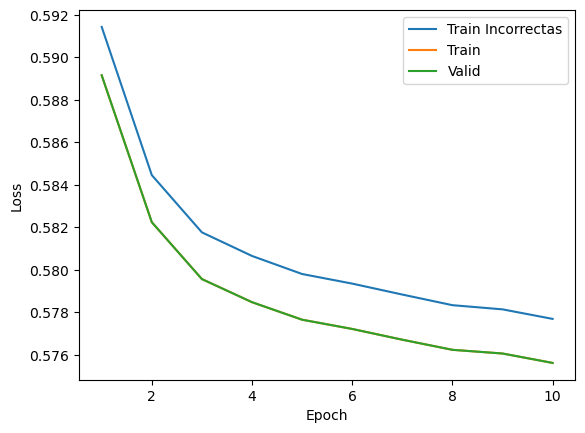

In [31]:
# 5.10)

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.plot(list(range(1, len(list_avg_train_loss_incorrecta)+1)), list_avg_train_loss, label='Train Incorrectas')
plt.plot(list(range(1, len(list_avg_train_loss)+1)), list_avg_valid_loss, label='Train')
plt.plot(list(range(1, len(list_avg_valid_loss)+1)), list_avg_valid_loss, label='Valid')

plt.legend()
plt.show()

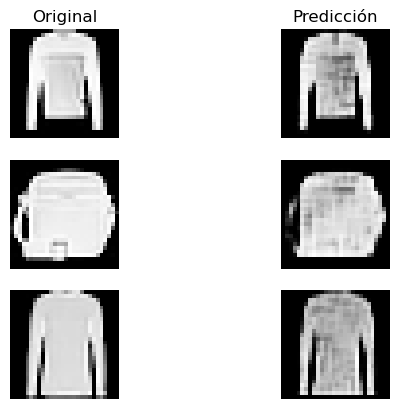

In [41]:
# Prueba del modelo sin entrenar

figure = plt.figure()
rows,cols = 3,2

i = 0

model.eval()

for row in range(1, rows+1):
    j = torch.randint(len(train_set),size=(1,)).item() # Los números aleatorios tambien se pueden generar desde pytorch. Util para trabajar en la GPU.  
    i += 1
    image, flatten_imagen = train_set[j]
    image = image.to(device)
    figure.add_subplot(rows, cols, i)

    if row == 1:
        plt.title('Original')
    plt.axis('off')

    plt.imshow(unbatch(image), cmap='Greys_r')

    i += 1
    figure.add_subplot(rows, cols, i)

    if row ==1:
        plt.title('Predicción')
    plt.axis('off')
    image_pred = unbatch(model(batch(image)))
    plt.imshow(image_pred, cmap='Greys_r')

plt.show()